Sumission 3 Image Classification Model Deployment

Image Classification TF-Lite

Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Read Data

In [2]:
!wget --no-check-certificate https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
-O /tmp/rockpaperscissors.zip

--2021-07-12 09:24:10--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  10.6MB/s    in 54s     

2021-07-12 09:25:04 (5.75 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [4]:
import zipfile,os

local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

os.listdir('/tmp')

['initgoogle_syslog_dir.0',
 'dap_multiplexer.143725a90f83.root.log.INFO.20210712-091753.54',
 'debugger_rqa1o8bar',
 '__MACOSX',
 'rockpaperscissors.zip',
 'dap_multiplexer.INFO',
 'rockpaperscissors']

In [11]:
pip install split-folders

In [12]:
pip install split-folders tqdm

In [19]:
import splitfolders

splitfolders.ratio('/tmp/rockpaperscissors/rps-cv-images', output="/tmp/rockpaperscissors/output_split", seed=1337, ratio=(.8, .2))
base_dir = '/tmp/rockpaperscissors/output_split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

Copying files: 2188 files [00:00, 3947.04 files/s]


In [20]:
os.listdir('/tmp/rockpaperscissors/output_split/train')

['rock', 'paper', 'scissors']

In [21]:
os.listdir('/tmp/rockpaperscissors/output_split/val')

['rock', 'paper', 'scissors']

In [23]:
# create rock directory in training data directory
train_rock_dir = os.path.join(train_dir, 'rock')
     
# create scissors directory in training data directory
train_scissors_dir = os.path.join(train_dir, 'scissors')

# create paper directoryr in training data directory
train_paper_dir = os.path.join(train_dir, 'paper')
     
# create rock directory in validation data directory
validation_rock_dir = os.path.join(validation_dir, 'rock')
     
# create scissors directory in validation data directory
validation_scissors_dir = os.path.join(validation_dir, 'scissors')

# create paper directory in validation data directory
validation_paper_dir = os.path.join(validation_dir, 'paper')

Data Preprocessing

In [26]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                shear_range = 0.2,
                fill_mode = 'nearest')
     
test_datagen = ImageDataGenerator(
               rescale=1./255,
               rotation_range=20,
               horizontal_flip=True,
               shear_range = 0.2,
               fill_mode = 'nearest')

In [28]:
train_generator = train_datagen.flow_from_directory(
            train_dir,  
            target_size=(150, 150),  
            batch_size=4,
            class_mode='categorical')
     
validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(150, 150), 
            batch_size=4, 
            class_mode='categorical')

Found 1749 images belonging to 3 classes.
Found 439 images belonging to 3 classes.


Building Model

In [35]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [36]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [44]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
      print("\nAccuracy above 95%, finish training!")
      self.model.stop_training = True

callbacks = myCallback()

In [45]:
history = model.fit(
            train_generator,
            steps_per_epoch=25,  
            epochs=20,
            validation_data=validation_generator, 
            validation_steps=5, 
            callbacks = [callbacks], 
            verbose=2)

Epoch 1/20
25/25 - 2s - loss: 0.1744 - accuracy: 0.9400 - val_loss: 0.1747 - val_accuracy: 0.9000
Epoch 2/20
25/25 - 2s - loss: 0.0623 - accuracy: 0.9900 - val_loss: 0.1708 - val_accuracy: 0.9000
Epoch 3/20
25/25 - 2s - loss: 0.0926 - accuracy: 0.9700 - val_loss: 0.0979 - val_accuracy: 1.0000

Accuracy above 95%, finish training!


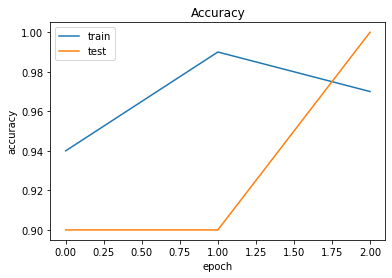

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

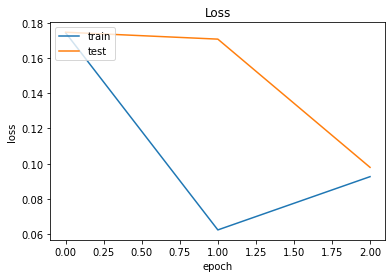

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

TF-Lite

In [48]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp9djo6h7e/assets


In [49]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [50]:
model.save('my_model.pb') 
%cd

INFO:tensorflow:Assets written to: my_model.pb/assets


INFO:tensorflow:Assets written to: my_model.pb/assets


/root
